# Checking the relation between team size and productivity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

In [2]:
# load the dataset
df = pd.read_csv('./refined.csv')

In [3]:
team_size = df.gh_team_size.unique()
sample_set = 100

src_sloc = np.zeros((sample_set, len(team_size)))
test_sloc = np.zeros((sample_set, len(team_size)))
status_failed = np.zeros((sample_set, len(team_size)))
status_passed = np.zeros((sample_set, len(team_size)))
test_failed = np.zeros((sample_set, len(team_size)))
test_ok = np.zeros((sample_set, len(team_size)))
date = np.zeros((sample_set, len(team_size)))
src_date_res = np.zeros((sample_set, len(team_size)))
test_date_res = np.zeros((sample_set, len(team_size)))

In [4]:
# Here we create 100 sampel set from our dataset with replacement
for i in range(sample_set):
    sample = df.sample(frac=1, replace=True)
    sample = sample.sort_values('gh_team_size')
    
    # In each sample test each of the values for team sie from 0 to 60
    for index, threshold in enumerate(team_size):
        if index == 0 or index == len(team_size) - 1:
            continue

        # Calculate the mean of each feature for each team size
        src = sample.groupby('gh_team_size', as_index=False)['git_diff_src_churn'].mean()
        test = sample.groupby('gh_team_size', as_index=False)['git_diff_test_churn'].mean()
        sloc = sample.groupby('gh_team_size', as_index=False)['gh_sloc'].mean()
        counts = sample.groupby(['gh_team_size']).size().reset_index(name='counts')
        failed = sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 0].tolist()
        passed = sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 1].tolist()
        failed_tests = df.groupby('gh_team_size', as_index=False)['tr_log_num_tests_failed'].mean()
        ok_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_ok'].mean()
        total_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_run'].mean()
        date_diff = sample.groupby('gh_team_size', as_index=False)['date_diff'].mean()
        src_date = sample.groupby('gh_team_size', as_index=False)['src_date'].mean()
        test_date = sample.groupby('gh_team_size', as_index=False)['test_date'].mean()
        
        sloc_list = sloc['gh_sloc'].tolist()
        test_list = test['git_diff_test_churn'].tolist()
        src_list = src['git_diff_src_churn'].tolist()
        failed_tests_list = failed_tests['tr_log_num_tests_failed'].tolist()
        total_tests_list = total_tests['tr_log_num_tests_run'].tolist()
        ok_tests_list = ok_tests['tr_log_num_tests_ok'].tolist()
        date_diff_list = date_diff['date_diff'].tolist()
        src_date_list = src_date['src_date'].tolist()
        test_date_list = test_date['test_date'].tolist()
        total_status = list(counts['counts'])

        lower_half_mean_src = np.mean(src_list[:index]) / np.mean(sloc_list[:index])
        upper_half_mean_src = np.mean(src_list[index:]) / np.mean(sloc_list[index:])
        
        lower_half_mean_test = np.mean(test_list[:index]) / np.mean(sloc_list[:index])
        upper_half_mean_test = np.mean(test_list[index:]) / np.mean(sloc_list[index:])
        
        lower_half_mean_failure = np.mean(failed[:index]) / np.mean(total_status[:index])
        upper_half_mean_failure = np.mean(failed[index:]) / np.mean(total_status[index:])

        lower_half_mean_passed = np.mean(passed[:index]) / np.mean(total_status[:index])
        upper_half_mean_passed = np.mean(passed[index:]) / np.mean(total_status[index:])
        
        lower_half_failed_tests = np.mean(failed_tests_list[:index]) / np.mean(total_tests_list[:index])
        upper_half_failed_tests = np.mean(failed_tests_list[index:]) / np.mean(total_tests_list[index:])
        
        lower_half_ok_tests = np.mean(ok_tests_list[:index]) / np.mean(total_tests_list[:index])
        upper_half_ok_tests = np.mean(ok_tests_list[index:]) / np.mean(total_tests_list[index:])
        
        lower_half_date_diff = np.mean(date_diff_list[:index])
        upper_half_date_diff = np.mean(date_diff_list[index:])
        
        lower_half_src_date = np.mean(src_date_list[:index])
        upper_half_src_date = np.mean(src_date_list[index:])
        
        lower_half_test_date = np.mean(test_date_list[:index])
        upper_half_test_date = np.mean(test_date_list[index:])

        # Get the difference of mean from two side of the threshold 
        src_sloc[i][index] = lower_half_mean_src - upper_half_mean_src
        test_sloc[i][index] = lower_half_mean_test - upper_half_mean_test
        status_failed[i][index] = lower_half_mean_failure - upper_half_mean_failure
        status_passed[i][index] = lower_half_mean_passed - upper_half_mean_passed
        test_failed[i][index] = lower_half_failed_tests - upper_half_failed_tests
        test_ok[i][index] = lower_half_ok_tests - upper_half_ok_tests
        date[i][index] = lower_half_date_diff - upper_half_date_diff
        src_date_res[i][index] = lower_half_src_date - upper_half_src_date
        test_date_res[i][index] = lower_half_test_date - upper_half_test_date

In [5]:
compare_src_sloc = src_sloc > 0
compare_test_sloc = test_sloc > 0
compare_status_failed = status_failed > 0
compare_status_passed = status_passed > 0
compare_test_failed = test_failed > 0
compare_test_ok = test_ok > 0
compare_date_dif = date > 0
compare_src_date = src_date_res > 0
compare_test_date = test_date_res > 0

In [6]:
sum_src_sloc = np.zeros(len(team_size))
sum_test_sloc = np.zeros(len(team_size))
sum_status_failed = np.zeros(len(team_size))
sum_status_passed = np.zeros(len(team_size))
sum_test_failed = np.zeros(len(team_size))
sum_test_ok = np.zeros(len(team_size))
sum_date_diff = np.zeros(len(team_size))
sum_src_date = np.zeros(len(team_size))
sum_test_date = np.zeros(len(team_size))
for i in range(len(team_size)):
    sum_src_sloc[i] = np.sum(compare_src_sloc[:, i])
    sum_test_sloc[i] = np.sum(compare_test_sloc[:, i])
    sum_status_failed[i] = np.sum(compare_status_failed[:, i])
    sum_status_passed[i] = np.sum(compare_status_passed[:, i])
    sum_test_failed[i] = np.sum(compare_test_failed[:, i])
    sum_test_ok[i] = np.sum(compare_test_ok[:, i])
    sum_date_diff[i] = np.sum(compare_date_dif[:, i])
    sum_src_date[i] = np.sum(compare_src_date[:, i])
    sum_test_date[i] = np.sum(compare_test_date[:, i])

In [7]:
mean_threshold = np.zeros(len(team_size))
for i in range(len(team_size)):
    mean_threshold[i] = np.mean(np.array([sum_src_sloc[i], sum_test_sloc[i], sum_status_failed[i], sum_status_passed[i], sum_test_failed[i], sum_test_ok[i], sum_src_date[i], sum_test_date[i]]))

In [8]:
selected = np.argmax(mean_threshold)
selected = 7
print(selected)

7


C:\Users\norouziy\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


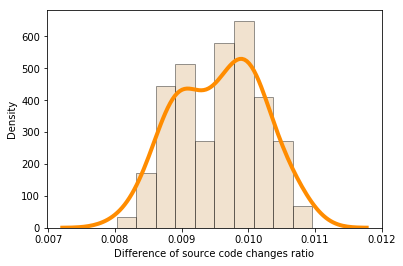

In [9]:
x = pd.Series(src_sloc[:, selected], name="Difference of source code changes ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='burlywood',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'darkorange'})
plt.ylabel("Density")
plt.savefig('./figs/src_sloc_ratio.eps', format='eps')

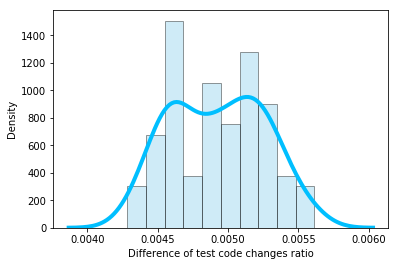

In [10]:
x = pd.Series(test_sloc[:, selected], name="Difference of test code changes ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='skyblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'deepskyblue'})
plt.ylabel("Density")
plt.savefig('./figs/test_sloc_ratio.eps', format='eps')

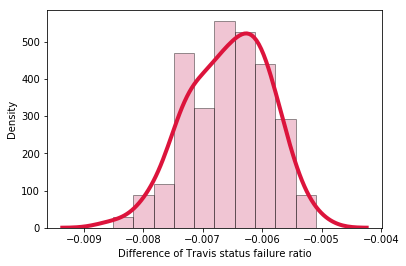

In [11]:
x = pd.Series(status_failed[:, selected], name="Difference of Travis status failure ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='palevioletred',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'crimson'})
plt.ylabel("Density")
plt.savefig('./figs/status_failed.eps', format='eps')

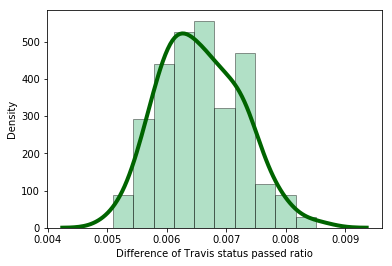

In [12]:
x = pd.Series(status_passed[:, selected], name="Difference of Travis status passed ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='mediumseagreen',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'darkgreen'})
plt.ylabel("Density")
plt.savefig('./figs/status_passed.eps', format='eps')

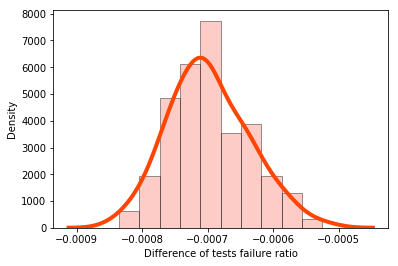

In [13]:
x = pd.Series(test_failed[:, selected], name="Difference of tests failure ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='salmon',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'orangered'})
plt.ylabel("Density")
plt.savefig('./figs/test_failed_ratio.eps', format='eps')

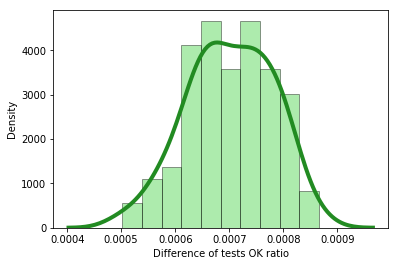

In [14]:
x = pd.Series(test_ok[:, selected], name="Difference of tests OK ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='limegreen',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'forestgreen'})
plt.ylabel("Density")
plt.savefig('./figs/test_ok_ratio.eps', format='eps')

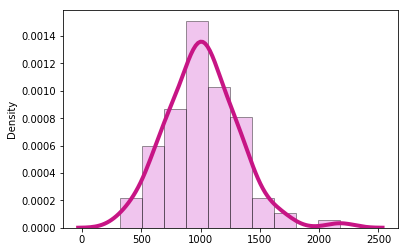

In [15]:
sns.distplot(date[:, selected], hist=True, kde=True,
                 bins=10, color='orchid',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'mediumvioletred'})
plt.ylabel("Density")
plt.savefig('./figs/date.eps', format='eps')

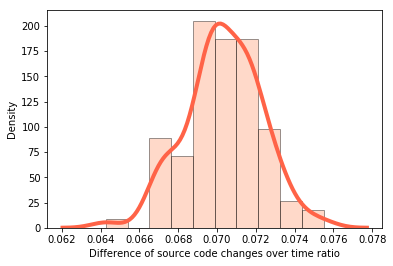

In [16]:
x = pd.Series(src_date_res[:, selected], name="Difference of source code changes over time ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='lightsalmon',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'tomato'})
plt.ylabel("Density")
plt.savefig('./figs/src_date_ratio.eps', format='eps')

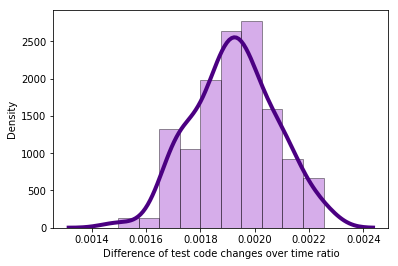

In [17]:
x = pd.Series(test_date_res[:, selected], name="Difference of test code changes over time ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='darkorchid',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4, 'color': 'indigo'})
plt.ylabel("Density")
plt.savefig('./figs/test_date_ratio.eps', format='eps')